# TM10007 Assignment
Made by: Sifra Kuiper, Imme Spiekerman, Florien Algera and Nico Frijns

**Explanation of what this code will achieve**

This part of the code will connect this document to the github-location where the data is stored.

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git
!pip install fast_ml --upgrade

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2.8

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git

  Preparing metadata (setup.py) ... done


## Pre-processing

Data loading






In [3]:
## HET SPLITSEN VAN DATA IN TRAINING EN DATA GROEP

## PRE-PROCESSING FUNCTIE VAN NICO
## PRE-PROCCESSING FUNCTIE TOEGEPAST OP DE TRAINING DATA

# Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data
import pandas as pd
data = load_data()

# Printing the demensions of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

#splitting data into X and y
y  = data['label']
X = data[data.columns[1:]]
y = pd.DataFrame(y)
X = pd.DataFrame(X)
print(f'The number of samples: {len(X.index)}')
print(f'The number of samples: {len(y.index)}')
# Counting the different labels
def ratio_lipoma_liposarcoma(y):
  lipoma = 0
  liposarcoma = 0
  for i in y['label']:
    if i == "lipoma":
      lipoma += 1
    else:
      liposarcoma += 1
  return f'Ratio van lipoma and liposarcoma is: {lipoma} : {liposarcoma}'
print(ratio_lipoma_liposarcoma(y))




The number of samples: 115
The number of columns: 494
The number of samples: 115
The number of samples: 115
Ratio van lipoma and liposarcoma is: 57 : 58


Splitting data

In [4]:
from sklearn.model_selection import train_test_split
# making the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

print(f'Train {ratio_lipoma_liposarcoma(y_train)}')
print(f'Test {ratio_lipoma_liposarcoma(y_test)}')

Train Ratio van lipoma and liposarcoma is: 45 : 47
Test Ratio van lipoma and liposarcoma is: 12 : 11


Check for duplicates

In [5]:
# check of there are no duplicated features and rows by using the index
if  data.index.is_unique:
  print('Features and rows are unique by name')
else:
  print('There is a duplicated features and/or rows by name')

#check of there are no dupliceted features regarding the data
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_duplicate_features
print(f'The number of columns: {len(X_train.columns)}')
print(f'The number of columns: {len(X_test.columns)}')

duplicate_features = get_duplicate_features(X_train)
duplicate_features.head()
duplicate_features_list = duplicate_features.query(
    "Desc=='Duplicate Values'")['feature2'].to_list()
X_train.drop(columns = duplicate_features_list, inplace=True)
X_test.drop(columns = duplicate_features_list, inplace=True)
print(f'The number of columns: {len(X_train.columns)}')
print(f'The number of columns: {len(X_test.columns)}')

Features and rows are unique by name
The number of columns: 493
The number of columns: 493
The number of columns: 467
The number of columns: 467


Check for variance

In [7]:
from sklearn.feature_selection import VarianceThreshold

# Record the column names and data types
original_columns_train = X_train.columns
original_dtypes_train = X_train.dtypes
# Create an instance of VarianceThreshold
selector = VarianceThreshold()

# Fit the selector to your training data
selector.fit(X_train)

# Get the indices of the features that are kept after feature selection
kept_features_indices = selector.get_support(indices=True)

# Get the names of the kept features
kept_features_names = X_train.columns[kept_features_indices]

# Transform the training data and create a new DataFrame with the kept features
relevant_features_train = selector.transform(X_train)
X_selected_train = pd.DataFrame(relevant_features_train,
                                columns=kept_features_names,
                                index=X_train.index)
# setting features back to orginale datatype
for column in X_selected_train.columns:
  if column in original_columns_train:
    X_selected_train[column] = X_selected_train[column].astype(
        original_dtypes_train[column])
# Print the original DataFrame, transformed DataFrame,
# and the number of zero-variance features
print("\nNumber of zero-variance features:", X_train.shape[1] -
      X_selected_train.shape[1])

# Test data same transformation as train
original_columns_test = X_test.columns
original_dtypes_test = X_test.dtypes
relevant_features_test = selector.transform(X_test)
X_selected_test = pd.DataFrame(relevant_features_test,
                               columns=kept_features_names, index=X_test.index)
for column in X_selected_test.columns:
  if column in original_columns_test:
    X_selected_test[column] = X_selected_test[column].astype(
        original_dtypes_test[column])



Number of zero-variance features: 7


Data Checking Type

In [8]:
X_selected_train.info()
# want to have the name of the int to check if it is a catogirsed data
integer_features = X_selected_train.select_dtypes(include='int64').columns.tolist()
print("Integer features:")
print(integer_features)

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, Lipo-032_0 to Lipo-103_0
Columns: 460 entries, PREDICT_original_sf_compactness_avg_2.5D to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(441), int64(19)
memory usage: 331.3+ KB
Integer features:
['PREDICT_original_hf_peak_position', 'PREDICT_original_logf_peak_position_sigma1', 'PREDICT_original_logf_peak_position_sigma5', 'PREDICT_original_logf_peak_position_sigma10', 'PREDICT_original_tf_LBP_peak_position_R3_P12', 'PREDICT_original_tf_LBP_peak_position_R15_P36', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.0', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.79', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A1.57', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A2.36', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A0.0', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A0.79', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A1.57', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A2.36', 'PREDICT_original_tf_G

Want to make a plot of all the int data to see if it is categorized data is.

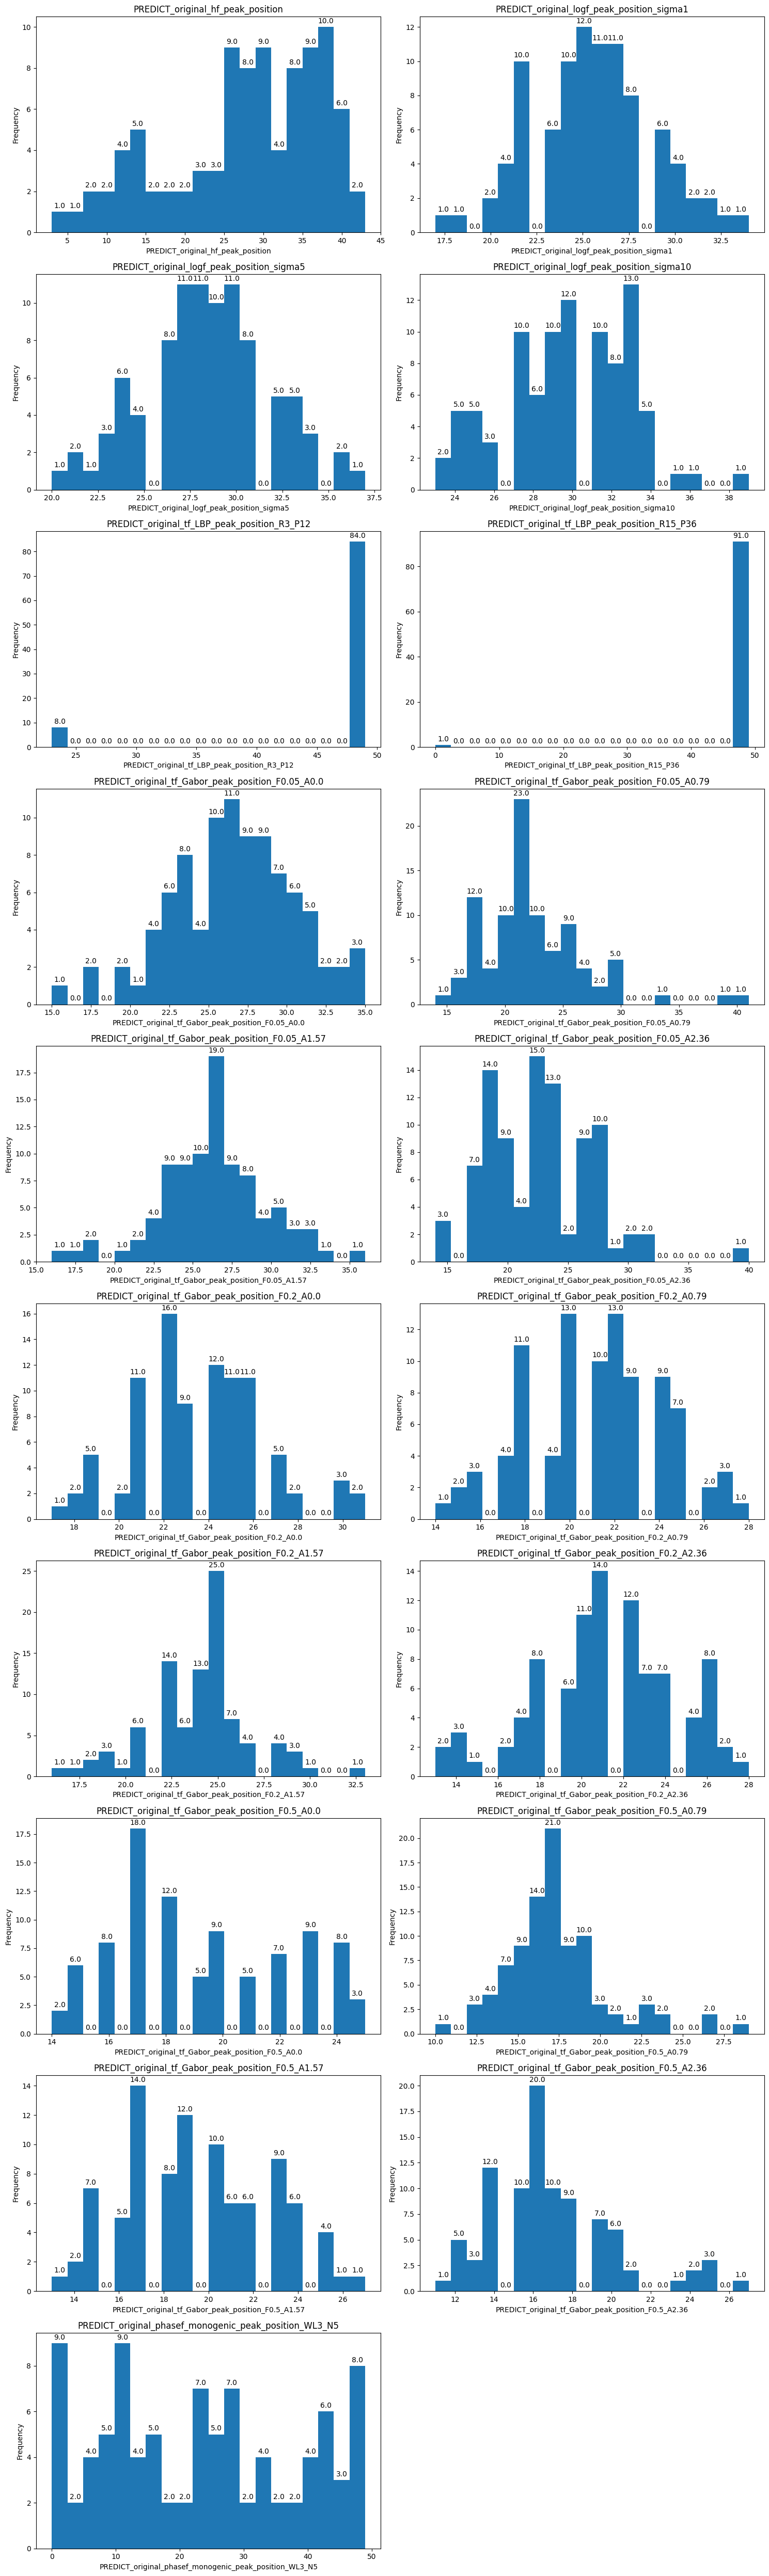

In [9]:
import matplotlib.pyplot as plt

# Assuming features_set is your set of features
num_features = len(integer_features)
num_cols = 2  # Number of columns in the subplot grid
num_rows = -(-num_features // num_cols)  # Ceiling division to calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, feature in enumerate(integer_features):
    if feature in X_selected_train.columns:
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        X_selected_train[feature].plot(kind='hist', bins=20, ax=axes[row, col], title=feature)
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Frequency')
        # Annotate each bar with its count
        for rect in ax.patches:
            height = rect.get_height()
            ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom')

# Hide empty subplots if the number of features is not a multiple of num_cols
for i in range(num_features, num_rows*num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

Check for outliers

In [10]:
Q1 = X_selected_train.quantile(0.25)
Q3 = X_selected_train.quantile(0.75)

# Calculate the IQR (Interquartile Range) for each column
IQR = Q3 - Q1

# Identify outliers using the IQR method
# Any value below Q1 - 1.5 * IQR
# or above Q3 + 1.5 * IQR is considered an outlier
outliers = ((X_selected_train < (Q1 - 1.5 * IQR)) |
 (X_selected_train > (Q3 + 1.5 * IQR))).sum().sum()

# Calculate the percentage of outliers
total_data_points = X_selected_train.size
total_percentage_outliers = (outliers / total_data_points) * 100

# Print the percentage of outliers for each column
print("Percentage of outliers:")
print(total_percentage_outliers)

Percentage of outliers:
4.881852551984877


Standardization

In [11]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_selected_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled,
                                 columns=X_selected_train.columns,
                                 index=X_selected_train.index)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_selected_train)
X_test_scaled_df = pd.DataFrame(X_test_scaled,
                                columns=X_selected_train.columns,
                                index=X_selected_train.index)


Data naiming

In [12]:
X_train = X_train_scaled_df
X_test = X_test_scaled_df

# Try PCA
-> Did not work, do not run this code

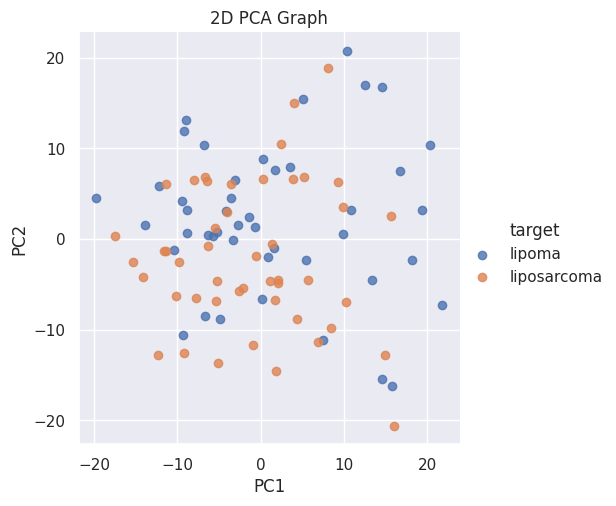

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import datasets
import seaborn as sns
import numpy as np

# Hyperparameters to tune:
numb_components = 70     # number of components

# Reduce from 4 to 3 features with PCA
pca = PCA(n_components=numb_components)

# Fit and transform data
pca_features = pca.fit_transform(X_train)

# Create a DataFrame from pca_features with column names 'PC1' and 'PC2'
pca_df = pd.DataFrame(data=pca_features[:, :2], columns=['PC1', 'PC2'])

pca_df = pca_df.rename(index=dict(zip(pca_df.index, y_train.index)))

# Add the labels from y_train to the DataFrame
pca_df['target'] = y_train

# Define target names mapping
target_names = {
    'lipoma': 'lipoma',
    'liposarcoma': 'liposarcoma'
}

# Map target names to the 'target' column in pca_df
pca_df['target'] = pca_df['target'].map(target_names)

# Set seaborn style
sns.set()

# Plot the PCA graph
sns.lmplot(
    x='PC1',
    y='PC2',
    data=pca_df,
    hue='target',
    fit_reg=False,  # Disable regression line
    legend=True
)

# Set plot title
plt.title('2D PCA Graph')

# Show the plot
plt.show()

## Choosing the right classifier

**Explanation of what is happening**


                 PC1        PC2       target
Lipo-032_0  7.403197 -11.162701       lipoma
Lipo-068_0 -5.085984 -13.679017  liposarcoma
Lipo-094_0 -2.728468   1.569493       lipoma
Lipo-110_0  9.867222   0.536301       lipoma
Lipo-023_0 -9.356967 -10.618458       lipoma
(92, 3)


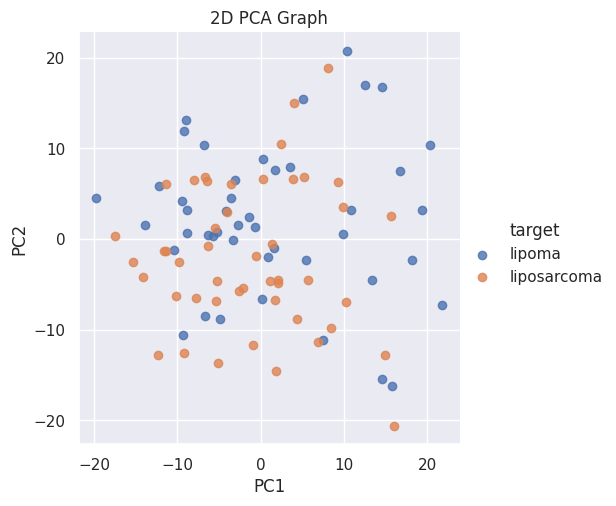

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming you have already computed pca_features using PCA and have labels stored in a Series called 'y_train'

# Create a DataFrame from pca_features with column names 'PC1' and 'PC2'
pca_df = pd.DataFrame(data=pca_features[:, :2], columns=['PC1', 'PC2'])

pca_df = pca_df.rename(index=dict(zip(pca_df.index, y_train.index)))

# Add the labels from y_train to the DataFrame
pca_df['target'] = y_train

print(pca_df.head())
print(pca_df.shape)

# Define target names mapping
target_names = {
    'lipoma': 'lipoma',
    'liposarcoma': 'liposarcoma'
}

# Map target names to the 'target' column in pca_df
pca_df['target'] = pca_df['target'].map(target_names)

# Set seaborn style
sns.set()

# Plot the PCA graph
sns.lmplot(
    x='PC1',
    y='PC2',
    data=pca_df,
    hue='target',
    fit_reg=False,  # Disable regression line
    legend=True
)

# Set plot title
plt.title('2D PCA Graph')

# Show the plot
plt.show()

In [15]:
#import pandas as pd
#from worclipo.load_data import load_data
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
#import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from sklearn import datasets
#from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

#Inladen data
#feature_data = load_data()
#X_train = feature_data.iloc[:, 2:]
#y_train = feature_data['label']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from statsmodels.sandbox.stats.multicomp import multipletests

# ---------------------FEATURE SELECTION -----------------------------------------------
# HYPERPARAMETER = aantal features om te selecteren

N1 = 6;
N2 = 10;
N3 = 50;

# Encode target variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# -------  ANOVA

# Compute F-statistics and p-values using f_classif
F_values, p_values = f_classif(X_train, y_train_encoded)

# Bonferroni correction on the p-values to correct for multiple testing
_, p_adjusted, _, alpha_corrected = multipletests(p_values, method='bonferroni')

# Create a DataFrame with feature names, F-values, and p-values
feature_stats_df = pd.DataFrame({'F-value': F_values, 'p-value': p_adjusted}, index=X_train.columns)

# Sort features based on absolute correlation values and select top 20
sorted_features_1 = feature_stats_df.abs().nlargest(N1, 'F-value')
sorted_features_2 = feature_stats_df.abs().nlargest(N2, 'F-value')
sorted_features_3 = feature_stats_df.abs().nlargest(N3, 'F-value')

# Maak nieuwe kleinere datasets met minder features
X_train_sel_1 = X_train.loc[:, sorted_features_1.index]
X_train_sel_2 = X_train.loc[:, sorted_features_2.index]
X_train_sel_3 = X_train.loc[:, sorted_features_3.index]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Visualization of the performance of the different classifiers**

## Optimalization of the GBDT classifier

**Explanation of code**

## Visualization of the performance of the trained classifier

<ipython-input-20-cdbd5bb783fb>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, y)


Accuracy for each fold: [0.57894737 0.68421053 0.72222222 0.88888889 0.83333333]
Accuracy for each fold: [0.57894737 0.68421053 0.83333333 0.83333333 0.72222222]
Accuracy for each fold: [0.57894737 0.73684211 0.77777778 0.77777778 0.77777778]
Mean accuracy: 0.7415204678362574
Mean accuracy: 0.7304093567251463
Mean accuracy: 0.7298245614035087


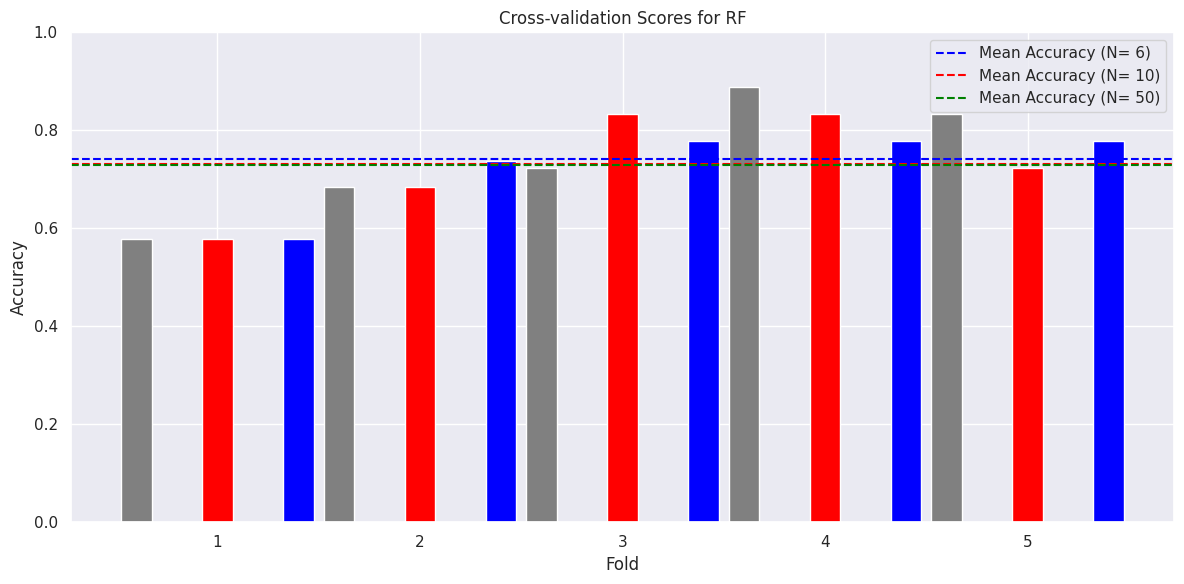

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

# Perform cross-validation
scores_sel_1_RF = cross_val_score(clf, X_train_sel_1, y_train_encoded, cv=5)
scores_sel_2_RF = cross_val_score(clf, X_train_sel_2, y_train_encoded, cv=5)
scores_sel_3_RF = cross_val_score(clf, X_train_sel_3, y_train_encoded, cv=5)
# Print the accuracy for each fold
print("Accuracy for each fold:", scores_sel_1_RF)
print("Accuracy for each fold:", scores_sel_2_RF)
print("Accuracy for each fold:", scores_sel_3_RF)

# Print the mean accuracy across all folds
print("Mean accuracy:", scores_sel_1_RF.mean())
print("Mean accuracy:", scores_sel_2_RF.mean())
print("Mean accuracy:", scores_sel_3_RF.mean())

# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_sel_1_RF = scores_sel_1_RF.mean()
plt.axhline(y=mean_accuracy_sel_1_RF, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N1})')
for i, score in enumerate(scores_sel_1_RF):
    plt.bar(i + 0.1, score, width=0.15, color='gray')

# Plot for selection 2
mean_accuracy_sel_2_RF = scores_sel_2_RF.mean()
plt.axhline(y=mean_accuracy_sel_2_RF, color='red', linestyle='--', label=f'Mean Accuracy (N= {N2})')
for i, score in enumerate(scores_sel_2_RF):
    plt.bar(i + 0.5, score, width=0.15, color='red')

# Plot for selection 3
mean_accuracy_sel_3_RF = scores_sel_3_RF.mean()
plt.axhline(y=mean_accuracy_sel_3_RF, color='green', linestyle='--', label=f'Mean Accuracy (N= {N3})')
for i, score in enumerate(scores_sel_3_RF):
    plt.bar(i + 0.9, score, width=0.15, color='blue')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-validation Scores for RF')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


Optimalizatie van Random Forest

In [22]:
from sklearn.model_selection import GridSearchCV

RF_to_opt = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(RF_to_opt, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sel_1, y_train_encoded)

# Get the best hyperparameters and the best score
print("Best parameters found by Grid Search:")
print(grid_search.best_params_)
print("Best accuracy found by Grid Search:", grid_search.best_score_)


Best parameters found by Grid Search:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best accuracy found by Grid Search: 0.7742690058479533


Accuracy for each fold: [0.57894737 0.68421053 0.72222222 0.94444444 0.83333333]
Mean accuracy: 0.7526315789473684


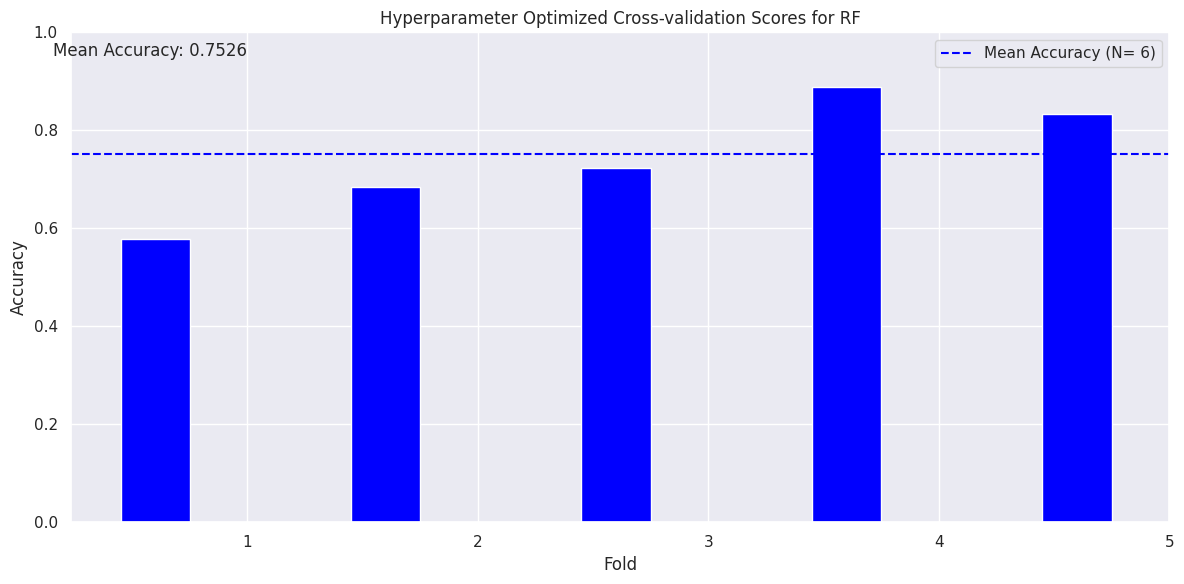

In [27]:
RF_opt = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators=300)
scores_opt_RF = cross_val_score(RF_opt, X_train_sel_1, y_train_encoded, cv=5)
# Print the accuracy for each fold
print("Accuracy for each fold:", scores_opt_RF)

# Print the mean accuracy across all folds
print("Mean accuracy:", scores_opt_RF.mean())

# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_opt_RF = scores_opt_RF.mean()
plt.axhline(y=mean_accuracy_opt_RF, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N1})')
plt.text(0.5, mean_accuracy_opt_RF + 0.20, f'Mean Accuracy: {mean_accuracy_opt_RF:.4f}', ha='right')
for i, score in enumerate(scores_sel_1_RF):
    plt.bar(i + 0.1, score, width=0.3, color='blue')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Optimized Cross-validation Scores for RF')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()